In [46]:
from functools import total_ordering

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

# Data formating

In [47]:
data = pd.read_csv(r"Z:\TC_Sydney_Uni_research_extract_202410.csv")
data = data[data['ROUTE'] == 'LGHTRL'].reset_index(drop=True)  # Filter by light train
data = data[['ORIGIN_DATE', 'ORIGIN_STOP', 'ORIGIN_STOP_XY',
             'DESTINATION_DATE', 'DESTINATION_STOP', 'DESTINATION_STOP_XY']]  # Filter columns by relevance

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136346 entries, 0 to 136345
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ORIGIN_DATE          136346 non-null  object
 1   ORIGIN_STOP          136346 non-null  object
 2   ORIGIN_STOP_XY       136346 non-null  object
 3   DESTINATION_DATE     136346 non-null  object
 4   DESTINATION_STOP     136346 non-null  object
 5   DESTINATION_STOP_XY  136346 non-null  object
dtypes: object(6)
memory usage: 6.2+ MB


In [48]:
# Delete the distinction between platforms in the origin and destination

def remove_platform(text):
    if 'Platform' in text:
        return text.split('Platform')[0].strip()
    return text

data['ORIGIN_STOP'] = data['ORIGIN_STOP'].map(remove_platform)
data['DESTINATION_STOP'] = data['DESTINATION_STOP'].map(remove_platform)

# Change the stops for an ID
stops_id = {'8100: Gungahlin Place': 0,
            '8101: Gungahlin Place': 0,
            '8104: Manning Clark Crescent': 1,
            '8105: Manning Clark Crescent': 1,
            '8106: Mapleton Avenue': 2,
            '8107: Mapleton Avenue': 2,
            '8108: Nullarbor Avenue': 3,
            '8109: Nullarbor Avenue': 3,
            '8110: Well Station Drive': 4,
            '8111: Well Station Drive': 4,
            '8114: EPIC and Racecourse': 5,
            '8116: Phillip Avenue': 6,
            '8117: Phillip Avenue': 6,
            '8118: Swinden Street': 7,
            '8119: Swinden Street': 7,
            '8120: Dickson': 8,
            '8121: Dickson': 8,
            '8122: Macarthur Avenue': 9,
            '8123: Macarthur Avenue': 9,
            '8124: Ipima Street': 10,
            '8125: Ipima Street': 10,
            '8126: Elouera Street': 11,
            '8127: Elouera Street': 11,
            '8128: Alinga Street': 12,
            '8129: Alinga Street': 12
            }

data['ORIGIN_STOP'] = data['ORIGIN_STOP'].replace(stops_id)
data['DESTINATION_STOP'] = data['DESTINATION_STOP'].replace(stops_id)

In [49]:
# Average demand between 7am and 8am
minimal_time = 8
maximal_time = 9

# Selected date
selected_date = pd.to_datetime('2024-09-18').date()

# To datetime
data['ORIGIN_DATE'] = pd.to_datetime(data['ORIGIN_DATE'], format='%Y-%m-%d %H:%M:%S')
data['DESTINATION_DATE'] = pd.to_datetime(data['DESTINATION_DATE'], format='%Y-%m-%d %H:%M:%S')
# Calculate only the time
data['ORIGIN_TIME'] = data['ORIGIN_DATE'].dt.hour * 60 + data['ORIGIN_DATE'].dt.minute
data['DESTINATION_TIME'] = data['DESTINATION_DATE'].dt.hour * 60 + data['DESTINATION_DATE'].dt.minute
# Filter by date
data['ORIGIN_DATE_DATE'] = data['ORIGIN_DATE'].dt.date
data = data[data['ORIGIN_DATE_DATE'] == selected_date]
# Filter by time
data = data[(data['ORIGIN_TIME'] >= minimal_time*60) & (data['ORIGIN_TIME'] < maximal_time*60)]
# Group demand
demand = data.groupby(['ORIGIN_STOP', 'DESTINATION_STOP']).size().reset_index(name='DEMAND')

demand.head()

,ORIGIN_STOP,DESTINATION_STOP,DEMAND
0,0,0,11
1,0,1,1
2,0,2,10
3,0,3,41
4,0,4,4


In [50]:
# Give the origin-destination matrix shape
demand = demand.pivot(columns='DESTINATION_STOP', index='ORIGIN_STOP', values='DEMAND')
# Make the diagonal zero
for i in range(demand.shape[0]):
    demand.loc[i,i] = 0
# Fill with zero
demand.fillna(0, inplace=True)
# Sort columns
demand = demand[sorted(demand.columns)]

demand

DESTINATION_STOP,0,1,2,3,4,5,6,7,8,9,10,11,12
ORIGIN_STOP,,,,,,,,,,,,,
0,0.0,1.0,10.0,41.0,4.0,0.0,4.0,9.0,84.0,5.0,15.0,21.0,394.0
1,9.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,14.0,0.0,2.0,8.0,49.0
2,34.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,32.0,3.0,9.0,4.0,115.0
3,19.0,0.0,0.0,0.0,3.0,0.0,2.0,1.0,14.0,5.0,1.0,10.0,92.0
4,8.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,14.0,0.0,4.0,4.0,102.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,15.0
6,4.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,4.0,1.0,2.0,1.0,56.0
7,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,64.0
8,16.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0,5.0,14.0,204.0


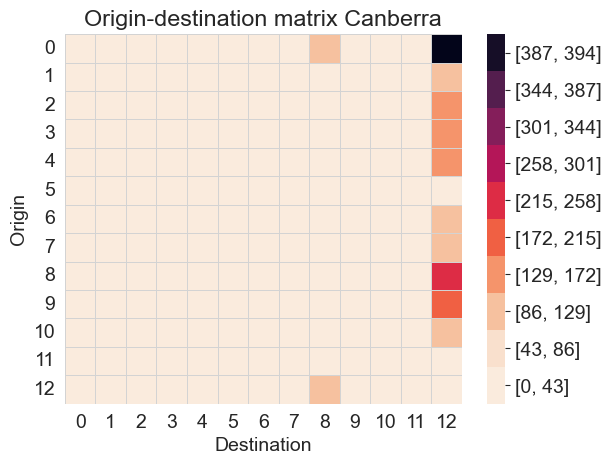

In [51]:
# Pasar la demanda a intervalos
data = demand.values.flatten()
deciles = np.arange(0, max(data), max(data)//9)

def assign_category(x):
    for index, item in enumerate(deciles):
        if x < item:
            return index-1
    return len(deciles)-1

demand_grouped = demand.map(assign_category)

# # Crear el mapa de calor usando matplotlib
# plt.figure(figsize=(8, 6))
# plt.imshow(demand_grouped, cmap='RdYlGn', interpolation='nearest')
# plt.colorbar(label='Valor')
# plt.xticks(ticks=np.arange(len(demand_grouped.index)), labels=demand.columns)
# plt.yticks(ticks=np.arange(len(demand_grouped.index)), labels=demand.index)
# plt.show()

ax = sns.heatmap(demand_grouped, linewidths=.5, linecolor='lightgray', cbar_kws={"boundaries": [-0.5, 0,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5, 9.5]}, cmap='rocket_r')
# ax = sns.heatmap(demand_grouped, linewidths=.5, linecolor='lightgray', cmap='rocket_r')


# Manually specify colorbar labelling after it's been generated
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.25, 0.25, 1, 2, 3, 4, 5, 6, 7, 8.5])
colorbar.set_ticklabels([f'[{int(deciles[i])}, {int(deciles[i+1])}]' for i in range(len(deciles)-1)] + [f'[{int(deciles[-1])}, {int(demand.max().max())}]'])

# X - Y axis labels
ax.set_ylabel('Origin')
ax.set_xlabel('Destination')

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
_, labels = plt.yticks()
plt.setp(labels, rotation=0)
plt.title('Origin-destination matrix Canberra')

plt.savefig('OD Canberra.png', dpi=300)
plt.show()

In [174]:
# To fabricate the travel times with google maps
travel_time = np.zeros((13,13))
travel_time[0,1] = 2
travel_time[1,2] = 1
travel_time[2,3] = 2
travel_time[3,4] = 2
travel_time[4,5] = 4
travel_time[5,6] = 2
travel_time[6,7] = 2
travel_time[7,8] = 2
travel_time[8,9] = 2
travel_time[9,10] = 2
travel_time[10,11] = 1
travel_time[11,12] = 2

for i in range(13):
    for j in range(i+1, 13):
        travel_time[i,j] = travel_time[i,j-1] + travel_time[j-1,j]
        travel_time[j,i] = travel_time[i,j]

travel_time = pd.DataFrame(travel_time)
# Minute to hour
travel_time = travel_time/60
travel_time

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.000000,0.033333,0.050000,0.083333,0.116667,0.183333,0.216667,0.250000,0.283333,0.316667,0.350000,0.366667,0.400000
1,0.033333,0.000000,0.016667,0.050000,0.083333,0.150000,0.183333,0.216667,0.250000,0.283333,0.316667,0.333333,0.366667
2,0.050000,0.016667,0.000000,0.033333,0.066667,0.133333,0.166667,0.200000,0.233333,0.266667,0.300000,0.316667,0.350000
3,0.083333,0.050000,0.033333,0.000000,0.033333,0.100000,0.133333,0.166667,0.200000,0.233333,0.266667,0.283333,0.316667
4,0.116667,0.083333,0.066667,0.033333,0.000000,0.066667,0.100000,0.133333,0.166667,0.200000,0.233333,0.250000,0.283333
5,0.183333,0.150000,0.133333,0.100000,0.066667,0.000000,0.033333,0.066667,0.100000,0.133333,0.166667,0.183333,0.216667
6,0.216667,0.183333,0.166667,0.133333,0.100000,0.033333,0.000000,0.033333,0.066667,0.100000,0.133333,0.150000,0.183333
7,0.250000,0.216667,0.200000,0.166667,0.133333,0.066667,0.033333,0.000000,0.033333,0.066667,0.100000,0.116667,0.150000
8,0.283333,0.250000,0.233333,0.200000,0.166667,0.100000,0.066667,0.033333,0.000000,0.033333,0.066667,0.083333,0.116667
9,0.316667,0.283333,0.266667,0.233333,0.200000,0.133333,0.100000,0.066667,0.033333,0.000000,0.033333,0.050000,0.083333


In [53]:
# # Calculate travel times
# data['TRAVEL_TIME_MINUTES'] = data['DESTINATION_TIME'] - data['ORIGIN_TIME']
# travel_time = data[['ORIGIN_STOP', 'DESTINATION_STOP', 'TRAVEL_TIME_MINUTES']].groupby(['ORIGIN_STOP', 'DESTINATION_STOP']).mean().reset_index()
# travel_time = travel_time.pivot(columns='DESTINATION_STOP', index='ORIGIN_STOP', values='TRAVEL_TIME_MINUTES')
#
# # Make the diagonal zero
# for i in range(travel_time.shape[0]):
#     travel_time.loc[i,i] = 0
# # Fill with zero
# travel_time.fillna(0, inplace=True)
# # Sort columns
# travel_time = travel_time[sorted(travel_time.columns)]
#
# travel_time

# DI implementation

In [175]:
def transfers_calculate(demand: pd.DataFrame) -> list[int]:
    """
    For each stop, calculate the potential transfers adding the two directions.
    """
    transfers_list = []
    for i in demand.index:
        # The transfers are the passengers traveling from before i to after i.
        trans = demand.loc[:i-1, i+1:].values.sum()
        # Also, the transfers are the passengers traveling from after i to before i.
        trans += demand.loc[i+1:, :i-1].values.sum()
        transfers_list.append(trans)

    return transfers_list

def max_flow_calculate(demand: pd.DataFrame) -> list[tuple[int, int]]:
    """
    For each stop, calculate the maximum flow before and after, including both directions.
    """
    # Calculate flow both directions in each segment
    flow_left = []
    flow_right = []
    for i in range(len(demand.index)-1):
        # Passengers traveling from before i to after i.
        flow_l = demand.loc[:i, i+1:].values.sum()
        flow_left.append(flow_l)
        # Passengers traveling from after i to before i.
        flow_r = demand.loc[i+1:, :i].values.sum()
        flow_right.append(flow_r)

    # Maximum flow by arc
    flow_max = [max(flow_left[i], flow_right[i]) for i in range(len(flow_left))]
    flow_max = np.array(flow_max)

    # Maximum flow both side division
    flow_max_division = [0]*len(demand.index)
    for i in range(1, len(demand.index)-1):
        flow_max_division[i] = (flow_max[:i].max(), flow_max[i:].max())

    return flow_max_division

def length_term_calculate(travel_time: pd.DataFrame, flow_max_division: list[tuple[int, int]]) -> list[int]:
    """
    For each stop, calculate |l_i| + |l_i|/|l|
    """
    length = [0]*len(travel_time.index)
    l = travel_time.loc[0,:].values.sum()
    for i in range(1, len(travel_time.index)-1):
        # The maximum flow segment is in the right
        if flow_max_division[i][0] < flow_max_division[i][1]:
            li = travel_time.loc[0,i]
        # The maximum flow segment is in the left
        else:
            li = travel_time.loc[i,travel_time.index[-1]]
        # Calculate and salve
        length[i] = li + li/l

    return length

def di_calculation(demand: pd.DataFrame, travel_time: pd.DataFrame, d1: float, d2: float) -> list[int]:
    """
    Divisibility index for each stop.
    """
    # Calculate the terms
    transfers = transfers_calculate(demand)
    flow_max_list = max_flow_calculate(demand)
    flow_max = max([item for f in flow_max_list[1:-2] for item in (f[0], f[1])])
    length = length_term_calculate(travel_time, flow_max_list)

    # Calculate the DI
    total_demand = demand.values.sum()
    divisibility = [0]*len(demand.index)
    for i in range(1, len(travel_time.index)-1):
        term1 = 1 - d1*transfers[i]/total_demand
        term2 = abs(flow_max_list[i][0] - flow_max_list[i][1]) / flow_max
        term3 = 1 + d2*length[i]
        divisibility[i] = term1 * term2 * term3

    return divisibility

In [179]:
transfers_calculate(demand)

[np.float64(0.0),
 np.float64(706.0),
 np.float64(741.0),
 np.float64(844.0),
 np.float64(963.0),
 np.float64(1097.0),
 np.float64(1100.0),
 np.float64(1162.0),
 np.float64(1056.0),
 np.float64(1324.0),
 np.float64(1446.0),
 np.float64(1451.0),
 np.float64(0.0)]

In [178]:
max_flow_calculate(demand)

[0,
 (np.float64(588.0), np.float64(1381.0)),
 (np.float64(666.0), np.float64(1381.0)),
 (np.float64(820.0), np.float64(1381.0)),
 (np.float64(902.0), np.float64(1381.0)),
 (np.float64(1021.0), np.float64(1381.0)),
 (np.float64(1039.0), np.float64(1381.0)),
 (np.float64(1096.0), np.float64(1381.0)),
 (np.float64(1153.0), np.float64(1381.0)),
 (np.float64(1216.0), np.float64(1381.0)),
 (np.float64(1353.0), np.float64(1381.0)),
 (np.float64(1381.0), np.float64(1322.0)),
 0]

In [177]:
length_term_calculate(travel_time, max_flow_calculate(demand))

[0,
 np.float64(0.045911949685534595),
 np.float64(0.0688679245283019),
 np.float64(0.11477987421383648),
 np.float64(0.1606918238993711),
 np.float64(0.25251572327044025),
 np.float64(0.29842767295597483),
 np.float64(0.3443396226415094),
 np.float64(0.390251572327044),
 np.float64(0.4361635220125786),
 np.float64(0.48207547169811316),
 np.float64(0.045911949685534595),
 0]

In [176]:
di_calculation(demand, travel_time, 0.9, 0.08)

[0,
 np.float64(0.39184678643673776),
 np.float64(0.34568963796451196),
 np.float64(0.2530790590736936),
 np.float64(0.1979188110198927),
 np.float64(0.13367005845385624),
 np.float64(0.12709884460259152),
 np.float64(0.1003345533345624),
 np.float64(0.0887369529281148),
 np.float64(0.04942167203571138),
 np.float64(0.007251703057177323),
 np.float64(0.01466978587040327),
 0]

In [59]:
# flujo hacia la derecha
subidas = []
for i in demand.index:
    subidas.append(demand.loc[i, i:].values.sum())

bajadas = []
for i in demand.index:
    bajadas.append(demand.loc[:i, i].values.sum())

flujos_explicito = pd.DataFrame({'subidas': subidas, 'bajadas':bajadas})
flujos_explicito['subidas acumuladas'] = flujos_explicito['subidas'].cumsum()
flujos_explicito['bajadas acumuladas'] = flujos_explicito['bajadas'].cumsum()
flujos_explicito['capacidad'] = flujos_explicito['subidas acumuladas']-flujos_explicito['bajadas acumuladas']
flujos_explicito

,subidas,bajadas,subidas acumuladas,bajadas acumuladas,capacidad
0,588.0,0.0,588.0,0.0,588.0
1,79.0,1.0,667.0,1.0,666.0
2,165.0,11.0,832.0,12.0,820.0
3,128.0,46.0,960.0,58.0,902.0
4,127.0,8.0,1087.0,66.0,1021.0
5,18.0,0.0,1105.0,66.0,1039.0
6,64.0,7.0,1169.0,73.0,1096.0
7,70.0,13.0,1239.0,86.0,1153.0
8,226.0,163.0,1465.0,249.0,1216.0
9,156.0,19.0,1621.0,268.0,1353.0


In [60]:
# flujo hacia la izquierda
subidas = []
for i in demand.index:
    subidas.append(demand.loc[i, :i].values.sum())

bajadas = []
for i in demand.index:
    bajadas.append(demand.loc[i:, i].values.sum())

flujos_explicito = pd.DataFrame({'subidas': subidas, 'bajadas':bajadas})
flujos_explicito['subidas acumuladas'] = flujos_explicito['subidas'][::-1].cumsum()
flujos_explicito['bajadas acumuladas'] = flujos_explicito['bajadas'][::-1].cumsum()
flujos_explicito['capacidad'] = flujos_explicito['subidas acumuladas']-flujos_explicito['bajadas acumuladas']
flujos_explicito

,subidas,bajadas,subidas acumuladas,bajadas acumuladas,capacidad
0,0.0,128.0,286.0,286.0,0.0
1,9.0,1.0,286.0,158.0,128.0
2,34.0,3.0,277.0,157.0,120.0
3,19.0,7.0,243.0,154.0,89.0
4,8.0,7.0,224.0,147.0,77.0
5,0.0,0.0,216.0,140.0,76.0
6,8.0,15.0,216.0,140.0,76.0
7,4.0,6.0,208.0,125.0,83.0
8,19.0,75.0,204.0,119.0,85.0
9,14.0,14.0,185.0,44.0,141.0


In [273]:
i=7
demand.loc[i, :i-1]

DESTINATION_STOP
0    3.0
1    0.0
2    0.0
3    1.0
4    0.0
5    0.0
6    0.0
Name: 7, dtype: float64

# Value of the consumed resources

In [285]:
def cost_users(demand: pd.DataFrame,
               travel_time: pd.DataFrame,
               frequency: list[float],
               board_alight_time: float,
               piv: float,
               pw: float,
               pr: float,
               divided_nodes: list[int]) -> float:
    """
    Total users cost, given the divisions of the corridor.
    """
    # Transfer cost
    transfers = np.array(transfers_calculate(demand))
    transfers = [transfers[i] if i in divided_nodes
                 else 0
                 for i in range(len(demand.index))]
    transfers_totales = sum(transfers)

    # Waiting time cost
    waiting_time = 0
    for i in range(len(demand.index)):
        line = find_line(divided_nodes=divided_nodes, stop=i)
        first_boarding_right = demand.loc[i, i+1:].sum()/(2*frequency[line])
        if i in divided_nodes:
            boarding_due_transfers = demand.loc[:i-1, i+1:].values.sum()/(2*frequency[line]) + demand.loc[i+1:, :i-1].values.sum()/(2*frequency[line-1])
            first_boarding_left = demand.loc[i, :i-1].sum()/(2*frequency[line-1])
        else:
            first_boarding_left = demand.loc[i, :i-1].sum()/(2*frequency[line])
            boarding_due_transfers = 0
        waiting_time += boarding_due_transfers + first_boarding_right + first_boarding_left

    # Travel time cost
    stop_state_right, stop_state_left = board_alight_calculate(demand)
    total_travel_time = 0
    # In-vehicle moving time
    for i in demand.index:
        for j in demand.columns:
            total_travel_time += demand.loc[i,j]*travel_time.loc[i,j]
    # In-vehicle stopped time
    for i in demand.index:
        line = find_line(divided_nodes=divided_nodes, stop=i)
        # Right
        # boarding and alighting passengers
        boarding = stop_state_right.loc[i, 'subidas']*board_alight_time/frequency[line]
        alight = stop_state_right.loc[i, 'bajadas']*board_alight_time/frequency[line]
        # Passengers on board waiting
        stopped_passengers = demand.loc[:i-1, i+1:].values.sum()
        total_travel_time += stopped_passengers*(boarding+alight)
        # Passengers alight
        avr_alight_time = stop_state_right.loc[i, 'bajadas']*board_alight_time/(2*frequency[line])
        total_travel_time += stop_state_right.loc[i, 'bajadas']*avr_alight_time

        if i in divided_nodes:
            line = line-1
        # Left
        # boarding and alighting passengers
        boarding = stop_state_left.loc[i, 'subidas']*board_alight_time/frequency[line]
        alight = stop_state_left.loc[i, 'bajadas']*board_alight_time/frequency[line]
        # Passengers on board waiting
        stopped_passengers = demand.loc[i+1:, :i-1].values.sum()
        total_travel_time += stopped_passengers*(boarding+alight)
        # Passengers alight
        avr_alight_time = stop_state_left.loc[i, 'bajadas']*board_alight_time/(2*frequency[line])
        total_travel_time += stop_state_left.loc[i, 'bajadas']*avr_alight_time

    return total_travel_time*piv + waiting_time*pw + transfers_totales*pr

def board_alight_calculate(demand: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    It calculares the board and alight for each stop, for both directions.
    """

    # flow through the right
    subidas = []
    for i in demand.index:
        subidas.append(demand.loc[i, i:].values.sum())

    bajadas = []
    for i in demand.index:
        bajadas.append(demand.loc[:i, i].values.sum())

    flujos_explicito_right = pd.DataFrame({'subidas': subidas, 'bajadas':bajadas})

    # flow through the left
    subidas = []
    for i in demand.index:
        subidas.append(demand.loc[i, :i].values.sum())

    bajadas = []
    for i in demand.index:
        bajadas.append(demand.loc[i:, i].values.sum())

    flujos_explicito_left = pd.DataFrame({'subidas': subidas, 'bajadas':bajadas})

    return flujos_explicito_right, flujos_explicito_left

def find_line(divided_nodes: list[int], stop: int) -> int:
    """
    Given the nodes where the corridor is divided, it gives you the line where a given stop belongs. The lines are numbered from 0 and growing to the right.
    """
    if len(divided_nodes) == 0:
        return 0
    for i in range(len(divided_nodes)):
        if stop < divided_nodes[i]:
            return i
    return len(divided_nodes)

def cost_operators(demand: pd.DataFrame,
                   travel_time: pd.DataFrame,
                   frequency: list[float],
                   board_alight_time: float,
                   c0: float,
                   c1: float,
                   divided_nodes: list[int]) -> float:
    """
    It calculates the operator cost.
    """
    # Calculate flow both directions in each segment
    flow_left = []
    flow_right = []
    for i in range(len(demand.index)-1):
        # Passengers traveling from before i to after i.
        flow_l = demand.loc[:i, i+1:].values.sum()
        flow_left.append(flow_l)
        # Passengers traveling from after i to before i.
        flow_r = demand.loc[i+1:, :i].values.sum()
        flow_right.append(flow_r)
    # Maximum flow by arc
    flow_max = [max(flow_left[i], flow_right[i]) for i in range(len(flow_left))]
    flow_max = np.array(flow_max)

    # Calculate transfers
    transfers = np.array(transfers_calculate(demand))

    total_cost = 0
    # Calculate the cost for each line
    for i in range(len(frequency)):

        # Line terminal stops
        # Only one line
        if len(frequency) == 1:
            first_node = 0
            last_node = len(demand.index)-1
        # First (not only) line
        elif i == 0:
            first_node = 0
            last_node = divided_nodes[i]
        # Other than first
        else:
            first_node = divided_nodes[i-1]
            if i == len(frequency) - 1:
                last_node = demand.index[-1]
            else:
                last_node = divided_nodes[i]

        # Maximum flow in the line
        flow_max_line = flow_max[first_node:last_node].max()
        # Capacity
        capacity = flow_max_line/frequency[i]

        # Cycle time
        total_travel_time = travel_time.loc[first_node, last_node]*2
        stop_state_right, stop_state_left = board_alight_calculate(demand)
        boarding_time = (stop_state_left.loc[first_node+1: last_node, 'subidas'].values.sum() +
                         stop_state_right.loc[first_node: last_node-1, 'subidas'].values.sum())
        alight_time = (stop_state_left.loc[first_node: last_node-1, 'bajadas'].values.sum() +
                         stop_state_right.loc[first_node+1: last_node, 'bajadas'].values.sum())
        extra_boarding_time_transfers = transfers[first_node]
        cycle_time = total_travel_time + (boarding_time + alight_time + extra_boarding_time_transfers)*board_alight_time/frequency[i]

        # Fleet size
        fleet = cycle_time*frequency[i]

        # Add cost
        total_cost += fleet*(c0 + c1*capacity)

    return total_cost

def vrc(demand: pd.DataFrame,
        travel_time: pd.DataFrame,
        frequency: list[float],
        divided_nodes: list[int],
        piv: float,
        pw: float,
        pr: float,
        board_alight_time: float,
        c0: float,
        c1: float) -> float:
    """
    It calculates the VRC.
    """

    users = cost_users(demand=demand,
                       travel_time=travel_time,
                       frequency=frequency,
                       board_alight_time=board_alight_time,
                       piv=piv,
                       pw=pw,
                       pr=pr,
                       divided_nodes=divided_nodes)

    operators = cost_operators(demand=demand,
                               travel_time=travel_time,
                               frequency=frequency,
                               board_alight_time=board_alight_time,
                               c0 = c0,
                               c1 = c1,
                               divided_nodes=divided_nodes)

    return users + operators

def vrc_fix(demand: pd.DataFrame,
            travel_time: pd.DataFrame,
            piv: float,
            board_alight_time: float,
            c0: float,
            c1: float) -> float:
    """
    Calculates the VRC components that doesn't vary with the frequency or the line divisions.
    """

    # Users travel time in motion
    travel_time_motion = 0
    # In-vehicle moving time
    for i in demand.index:
        for j in demand.columns:
            travel_time_motion += demand.loc[i,j]*travel_time.loc[i,j]
    users_vrc_fix = travel_time_motion*piv

    # Operators
    cicle_time_motion = travel_time.loc[0, travel_time.index[-1]]
    total_demand = demand.values.sum()
    # Calculate flow both directions in each segment
    flow_left = []
    flow_right = []
    for i in range(len(demand.index)-1):
        # Passengers traveling from before i to after i.
        flow_l = demand.loc[:i, i+1:].values.sum()
        flow_left.append(flow_l)
        # Passengers traveling from after i to before i.
        flow_r = demand.loc[i+1:, :i].values.sum()
        flow_right.append(flow_r)
    # Minimum flow by arc
    flow_min = min(flow_left + flow_right)
    operators_vrc_fix = 2*board_alight_time*c0*total_demand + cicle_time_motion*flow_min*c1

    return users_vrc_fix + operators_vrc_fix

def vrc_optimization(demand: pd.DataFrame,
                     travel_time: pd.DataFrame,
                     divided_nodes: list[int],
                     piv: float,
                     pw: float,
                     pr: float,
                     board_alight_time: float,
                     c0: float,
                     c1: float) -> tuple[tuple[float], float]:
    """
    It calculates the optimal frequency to minimize the VRC.
    """
    def vrc_auxiliar(freq):
        vrc_value = vrc(demand=demand,
                        travel_time=travel_time,
                        frequency=freq,
                        divided_nodes=divided_nodes,
                        piv=piv,
                        pw=pw,
                        pr=pr,
                        board_alight_time=board_alight_time,
                        c0=c0,
                        c1=c1)

        return vrc_value

    # Minimization
    initial_freq = [30]*(len(divided_nodes)+1)
    bounds = [(1, 300)]*len(initial_freq)
    result = minimize(vrc_auxiliar, initial_freq, bounds=bounds)

    optimal_freq = result.x
    optimal_vrc = result.fun

    return optimal_freq, optimal_vrc

# Numerical calculations

In [294]:
c0 = 8.61
c1 = 0.3
piv = 2.74
pw = 5.48
pr = 16*piv / 60
t = 0.0416 / 60

plt.rcdefaults()
plt.rcParams.update({'font.size': 14})

In [295]:
# Figures data

# DI values per stop
di_values = di_calculation(demand=demand,
                           travel_time=travel_time,
                           d1=0.9,
                           d2=0.08)

# City fixed cost
vrc_fix_cost = vrc_fix(demand=demand,
                       travel_time=travel_time,
                       piv=piv,
                       board_alight_time=t,
                       c0=c0,
                       c1=c1)

# Optimal VRC and frequencies per divisions
vrc_optimal_divisions = []
freq_optimal_divisions = []
for i in range(1, len(demand.index)-1):
    fo, vo  = vrc_optimization(demand=demand,
                                  travel_time=travel_time,
                                  divided_nodes=[i],
                                  piv=piv,
                                  pw=pw,
                                  pr=pr,
                                  board_alight_time=t,
                                  c0=c0,
                                  c1=c1)
    vrc_optimal_divisions.append(vo)
    freq_optimal_divisions.append(fo)

# Optimal complete line
freq_optimal_complete, vrc_optimal_complete = vrc_optimization(demand=demand,
                                                                travel_time=travel_time,
                                                                divided_nodes=[],
                                                                piv=piv,
                                                                pw=pw,
                                                                pr=pr,
                                                                board_alight_time=t,
                                                                c0=c0,
                                                                c1=c1)

In [253]:
cost_operators(demand=demand,
               travel_time=travel_time,
               frequency=[freq_optimal_complete],
               board_alight_time=t,
               c0 = c0,
               c1 = c1,
               divided_nodes=[])

array([669.12502023])

In [254]:
cost_operators(demand=demand,
               travel_time=travel_time,
               frequency=freq_optimal_divisions[8],
               board_alight_time=t,
               c0 = c0,
               c1 = c1,
               divided_nodes=[8])

np.float64(680.0774081971574)

In [288]:
cost_users(demand=demand,
                       travel_time=travel_time,
                       frequency=[freq_optimal_complete],
                       board_alight_time=t,
                       piv=piv,
                       pw=pw,
                       pr=pr,
                       divided_nodes=[])

array([1509.19007809])

In [291]:
cost_users(demand=demand,
                       travel_time=travel_time,
                       frequency=freq_optimal_divisions[8],
                       board_alight_time=t,
                       piv=piv,
                       pw=pw,
                       pr=pr,
                       divided_nodes=[8])

np.float64(2278.696846800096)

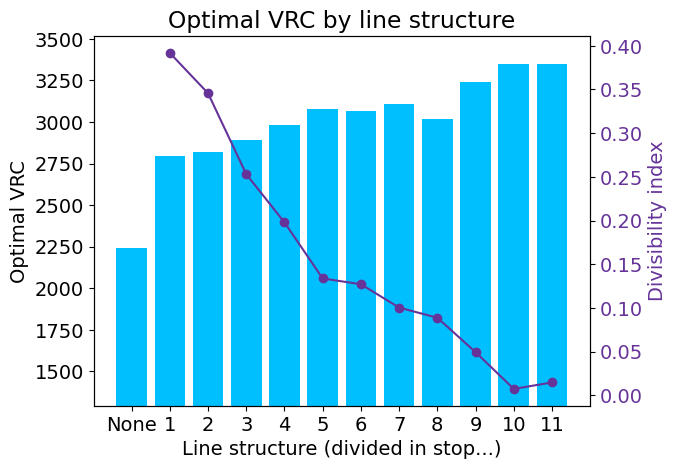

In [211]:
# Plot

# Datos de ejemplo
categories = ['None'] + [f'{i}' for i in range(1, len(demand.index)-1)]
values = [vrc_optimal_complete] + vrc_optimal_divisions

# Crear gráfico de barras
fig, ax1 = plt.subplots()
ax1.bar(categories, values, color='deepskyblue')

# Añadir título y etiquetas
ax1.set_xlabel('Line structure (divided in stop...)')
ax1.set_ylabel('Optimal VRC')
ax1.set_ylim(bottom=vrc_fix_cost)


# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(categories[1:], di_values[1:-1], color='rebeccapurple', marker='o', label='DI')
ax2.set_ylabel('Divisibility index', color='rebeccapurple')
ax2.tick_params(axis='y', labelcolor='rebeccapurple')

# Mostrar el gráfico
plt.title('Optimal VRC by line structure')
# plt.savefig('Optimal VRC by line structure.png', bbox_inches = 'tight')
plt.show()


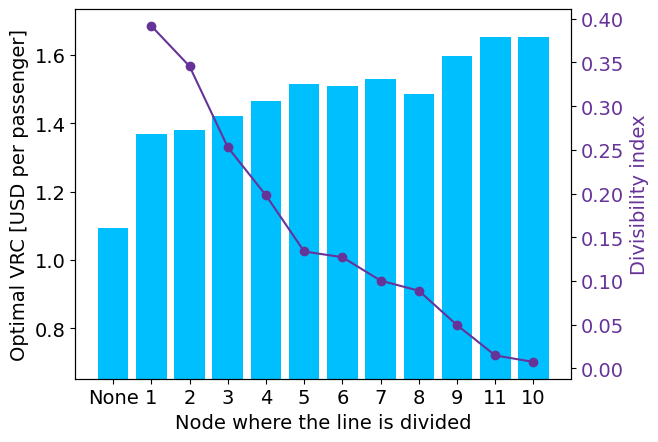

In [303]:
# Datos de ejemplo
total_demand = demand.values.sum()
categories = [f'{i}' for i in range(1, len(demand.index)-1)]
values = vrc_optimal_divisions

# Ordenar los datos por valor en orden ascendente
sorted_data = sorted(zip(categories, values, di_values[1:-1]), key=lambda x: x[2], reverse=True)
categories, values, di_values_sorted = zip(*sorted_data)
# Agregar estructura sin divisiones
categories = ['None'] + list(categories)
values = [vrc_optimal_complete] + list(values)
values = values/total_demand

# Crear gráfico de barras
fig, ax1 = plt.subplots()
ax1.bar(categories, values, color='deepskyblue')

# Añadir título y etiquetas
ax1.set_xlabel('Node where the line is divided')
ax1.set_ylabel('Optimal VRC [USD per passenger]')
ax1.set_ylim(bottom=vrc_fix_cost/total_demand)

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(categories[1:], di_values_sorted, color='rebeccapurple', marker='o')
ax2.set_ylabel('Divisibility index', color='rebeccapurple')
ax2.tick_params(axis='y', labelcolor='rebeccapurple')

# Mostrar el gráfico
# plt.title('Optimal VRC by line structure')
plt.savefig('Optimal VRC by line structure sorted.png', bbox_inches = 'tight')
plt.show()


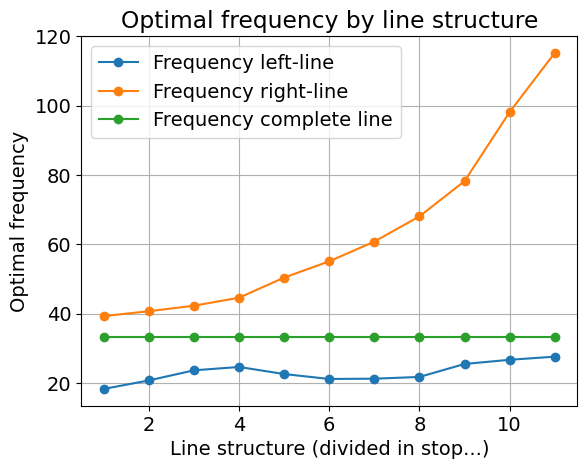

In [190]:
x = [i for i in range(1, len(demand.index)-1)]
freq_optimal_divisions_left = [f[0] for f in freq_optimal_divisions]
freq_optimal_divisions_right = [f[1] for f in freq_optimal_divisions]

fig, ax = plt.subplots()
ax.plot(x, freq_optimal_divisions_left, marker='o', label='Frequency left-line')
ax.plot(x, freq_optimal_divisions_right, marker='o', label='Frequency right-line')
ax.plot(x, [freq_optimal_complete]*len(x), marker='o', label='Frequency complete line')

ax.set_xlabel('Line structure (divided in stop...)')
ax.set_ylabel('Optimal frequency')
ax.legend()

plt.title('Optimal frequency by line structure')
plt.grid()
# plt.savefig('Optimal frequency by line structure.png', bbox_inches = 'tight')
plt.show()

In [121]:
# Fleet size

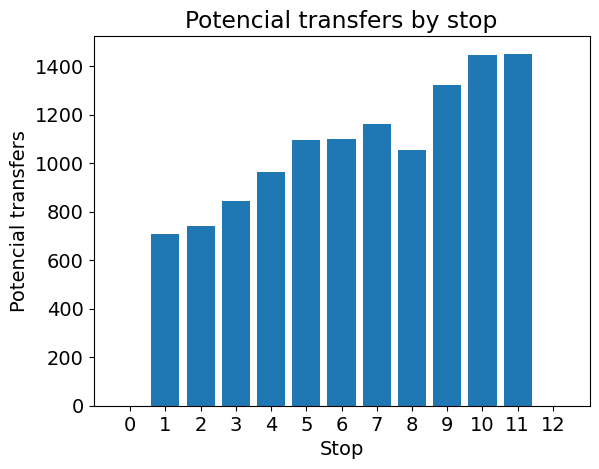

In [122]:
# Calculate transfers
transfers = transfers_calculate(demand=demand)
categories = [i for i in range(len(transfers))]

fig, ax = plt.subplots()
ax.bar(categories, transfers)
ax.set_xlabel('Stop')
ax.set_ylabel('Potencial transfers')

plt.title('Potencial transfers by stop')
plt.xticks(categories)
plt.show()

# Modified demand

In [235]:
demand_modified = demand.copy()
factor = 15

# Increase the demand in the line 0 to 8
demand_modified.loc[:8, :8] = demand.loc[:8, :8]*factor
# Increase the alight at 8
demand_modified.loc[:, 8] = demand.loc[:, 8]*factor
# Decrease the transfers at 8
demand_modified.loc[:7, 9:] = demand.loc[:7, 9:]/factor
# Decrease the demand in the line 8 to 12
demand_modified.loc[8:, 8:] = demand.loc[8:, 8:]/factor

normalization_coef = demand.values.sum()/demand_modified.values.sum()
demand_modified = (demand_modified*normalization_coef).round().astype(int)

In [444]:
demand_modified = demand.copy()
factor = 0.9
factor_shift = 0.6

# Increase the alight at 8
for i in range(8):
    demand_modified.loc[i, 8] = demand.loc[i, 8] + demand.loc[i, 9:12].sum()*factor
    demand_modified.loc[i, 9:12] = demand.loc[i, 9:12] - demand.loc[i, 9:12]*factor
for i in range(9, 13):
    demand_modified.loc[i, 8] = demand_modified.loc[i, 8] + demand.loc[i, 0:7].sum()*factor
    demand_modified.loc[i, 0:7] = demand_modified.loc[i, 0:7] - demand.loc[i, 0:7]*factor

# Shift the demand after 8
shift_value = 4
for i in range(8, 13):
    for j in range(8, i-1):
        demand_modified.loc[i-shift_value,j-shift_value] = demand.loc[i-shift_value,j-shift_value] + demand.loc[i,j]*factor_shift
        demand_modified.loc[i,j] = demand.loc[i,j] - demand.loc[i,j]*factor_shift

# for i in range(9, 13):
    for j in range(i+1, 13):
        demand_modified.loc[i-shift_value,j-shift_value] = demand.loc[i-shift_value,j-shift_value] + demand.loc[i,j]*factor_shift
        demand_modified.loc[i,j] = demand.loc[i,j] - demand.loc[i,j]*factor_shift


In [439]:
demand.loc[8:, 8:].values.sum()

np.float64(579.0)

In [440]:
demand_modified.loc[8:, 8:].values.sum()

np.float64(76.80000000000001)

In [449]:
board_alight_calculate(demand)[0]

,subidas,bajadas
0,588.0,0.0
1,79.0,1.0
2,165.0,11.0
3,128.0,46.0
4,127.0,8.0
5,18.0,0.0
6,64.0,7.0
7,70.0,13.0
8,226.0,163.0
9,156.0,19.0


In [448]:
max

,subidas,bajadas,subidas acumuladas,bajadas acumuladas,capacidad
0,0.0,128.0,286.0,286.0,0.0
1,9.0,1.0,286.0,158.0,128.0
2,34.0,3.0,277.0,157.0,120.0
3,19.0,7.0,243.0,154.0,89.0
4,8.0,7.0,224.0,147.0,77.0
5,0.0,0.0,216.0,140.0,76.0
6,8.0,15.0,216.0,140.0,76.0
7,4.0,6.0,208.0,125.0,83.0
8,19.0,75.0,204.0,119.0,85.0
9,14.0,14.0,185.0,44.0,141.0


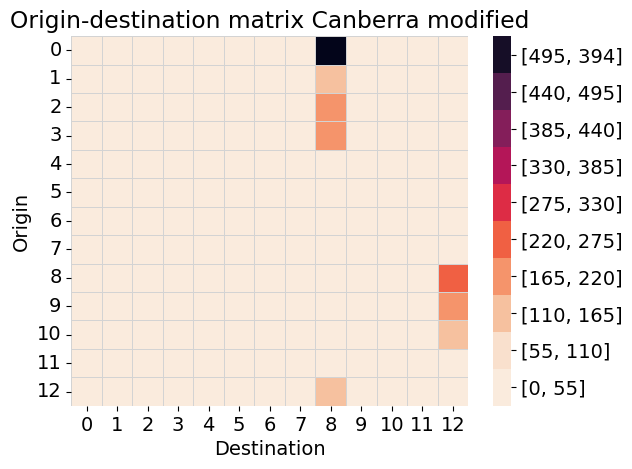

In [430]:
# Pasar la demanda a intervalos
data = demand_modified.values.flatten()
deciles = np.arange(0, max(data), max(data)//9)

def assign_category(x):
    for index, item in enumerate(deciles):
        if x < item:
            return index-1
    return len(deciles)-1

demand_grouped = demand_modified.map(assign_category)

ax = sns.heatmap(demand_grouped, linewidths=.5, linecolor='lightgray', cbar_kws={"boundaries": [-0.5, 0,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5, 9.5]}, cmap='rocket_r')

# Manually specify colorbar labelling after it's been generated
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.25, 0.25, 1, 2, 3, 4, 5, 6, 7, 8.5])
colorbar.set_ticklabels([f'[{int(deciles[i])}, {int(deciles[i+1])}]' for i in range(len(deciles)-1)] + [f'[{int(deciles[-1])}, {int(demand.max().max())}]'])

# X - Y axis labels
ax.set_ylabel('Origin')
ax.set_xlabel('Destination')

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
_, labels = plt.yticks()
plt.setp(labels, rotation=0)
plt.title('Origin-destination matrix Canberra modified')

# plt.savefig('OD Canberra modified.png', dpi=300)
plt.show()


In [431]:
# Figures data

# DI values per stop
di_values = di_calculation(demand=demand_modified,
                           travel_time=travel_time,
                           d1=0.9,
                           d2=0.08)

# City fixed cost
vrc_fix_cost = vrc_fix(demand=demand_modified,
                       travel_time=travel_time,
                       piv=piv,
                       board_alight_time=t,
                       c0=c0,
                       c1=c1)

# Optimal VRC and frequencies per divisions
vrc_optimal_divisions = []
freq_optimal_divisions = []
for i in range(1, len(demand_modified.index)-1):
    fo, vo  = vrc_optimization(demand=demand_modified,
                                  travel_time=travel_time,
                                  divided_nodes=[i],
                                  piv=piv,
                                  pw=pw,
                                  pr=pr,
                                  board_alight_time=t,
                                  c0=c0,
                                  c1=c1)
    vrc_optimal_divisions.append(vo)
    freq_optimal_divisions.append(fo)

# Optimal complete line
freq_optimal_complete, vrc_optimal_complete = vrc_optimization(demand=demand_modified,
                                                                travel_time=travel_time,
                                                                divided_nodes=[],
                                                                piv=piv,
                                                                pw=pw,
                                                                pr=pr,
                                                                board_alight_time=t,
                                                                c0=c0,
                                                                c1=c1)

In [418]:
max_flow_calculate(demand_modified)[8]


(np.float64(1192.2999999999997), np.float64(270.4))

In [421]:
transfers_calculate(demand_modified)[8]

np.float64(105.59999999999997)

In [415]:
cost_operators(demand=demand_modified,
               travel_time=travel_time,
               frequency=[freq_optimal_complete],
               board_alight_time=t,
               c0 = c0,
               c1 = c1,
               divided_nodes=[])

array([569.36370282])

In [416]:
cost_operators(demand=demand_modified,
               travel_time=travel_time,
               frequency=freq_optimal_divisions[8],
               board_alight_time=t,
               c0 = c0,
               c1 = c1,
               divided_nodes=[8])

np.float64(500.9480235701593)

In [406]:
cost_users(demand=demand_modified,
                       travel_time=travel_time,
                       frequency=[freq_optimal_complete],
                       board_alight_time=t,
                       piv=piv,
                       pw=pw,
                       pr=pr,
                       divided_nodes=[])

array([1106.35375877])

In [407]:
cost_users(demand=demand_modified,
                       travel_time=travel_time,
                       frequency=freq_optimal_divisions[8],
                       board_alight_time=t,
                       piv=piv,
                       pw=pw,
                       pr=pr,
                       divided_nodes=[8])

np.float64(1187.1998997720907)

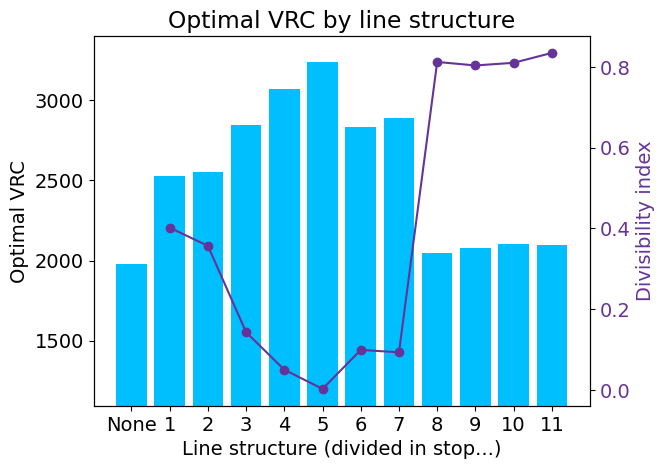

In [313]:
# Plot

# Datos de ejemplo
categories = ['None'] + [f'{i}' for i in range(1, len(demand_modified.index)-1)]
values = [vrc_optimal_complete] + vrc_optimal_divisions

# Crear gráfico de barras
fig, ax1 = plt.subplots()
ax1.bar(categories, values, color='deepskyblue')

# Añadir título y etiquetas
ax1.set_xlabel('Line structure (divided in stop...)')
ax1.set_ylabel('Optimal VRC')
ax1.set_ylim(bottom=vrc_fix_cost)


# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(categories[1:], di_values[1:-1], color='rebeccapurple', marker='o', label='DI')
ax2.set_ylabel('Divisibility index', color='rebeccapurple')
ax2.tick_params(axis='y', labelcolor='rebeccapurple')

# Mostrar el gráfico
plt.title('Optimal VRC by line structure')
# plt.savefig('Optimal VRC by line structure modified.png', bbox_inches = 'tight')
plt.show()

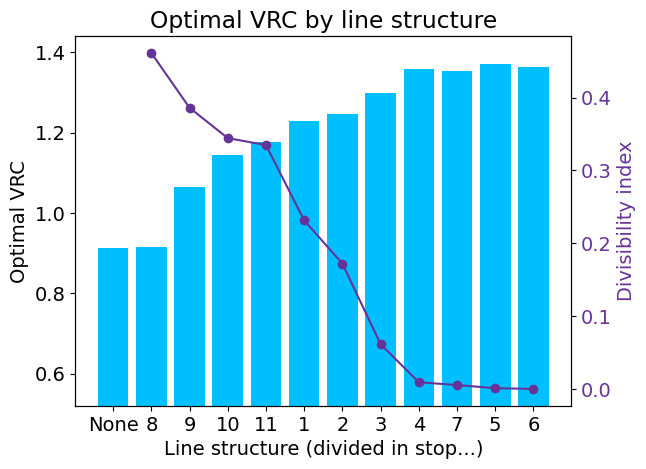

In [432]:
# Datos de ejemplo
total_demand = demand_modified.values.sum()
categories = [f'{i}' for i in range(1, len(demand_modified.index)-1)]
values = vrc_optimal_divisions

# Ordenar los datos por valor en orden ascendente
sorted_data = sorted(zip(categories, values, di_values[1:-1]), key=lambda x: x[2], reverse=True)
categories, values, di_values_sorted = zip(*sorted_data)
# Agregar estructura sin divisiones
categories = ['None'] + list(categories)
values = [vrc_optimal_complete] + list(values)
values = values/total_demand

# Crear gráfico de barras
fig, ax1 = plt.subplots()
ax1.bar(categories, values, color='deepskyblue')

# Añadir título y etiquetas
ax1.set_xlabel('Line structure (divided in stop...)')
ax1.set_ylabel('Optimal VRC')
ax1.set_ylim(bottom=vrc_fix_cost/total_demand)

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(categories[1:], di_values_sorted, color='rebeccapurple', marker='o')
ax2.set_ylabel('Divisibility index', color='rebeccapurple')
ax2.tick_params(axis='y', labelcolor='rebeccapurple')

# Mostrar el gráfico
plt.title('Optimal VRC by line structure')
# plt.savefig('Optimal VRC by line structure sorted modified.png', bbox_inches = 'tight')
plt.show()

In [433]:
vrc_optimal_divisions[8]

np.float64(1796.6325840046857)

In [434]:
vrc_optimal_complete

np.float64(1538.7938773187786)